In [157]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn
# plt.style.use('seaborn-white')
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

## Git-python: checkout master branch

In [158]:
rmg_model_path = "../../../meOH-synthesis"
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = time.strftime("%Y_%m_%d_%H%M", date)
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
git_file_string = f"{git_date}_{git_sha}_{git_msg}"
current_commit = git_file_string
current_commit

'2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates'

## checkout 1 commit back

In [159]:
# repo.git.checkout('HEAD^1')
# date = time.localtime(repo.head.commit.committed_date)
# git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
# git_sha = str(repo.head.commit)[0:6]
# git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
# git_file_string = f"{git_date}_{git_sha}_{git_msg}"
# current_commit = git_file_string

## checkout 2 commits back

In [160]:
# repo.git.checkout('HEAD^1')
# date = time.localtime(repo.head.commit.committed_date)
# git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
# git_sha = str(repo.head.commit)[0:6]
# git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
# git_file_string = f"{git_date}_{git_sha}_{git_msg}"
# current_commit = git_file_string

## Read in data

In [161]:
commit_list = []

# determine which files/folder to exclude

# exclude grabow data
grabow = False
grabow_str = "0000_00_00_0000_000000_Grabow model"
test_csv = "average_common_sensitivities"
single_csv = "single_reactor_results.csv"

if grabow: 
    exclude_files = [test_csv, single_csv]
else: 
    exclude_files = [grabow_str, test_csv, single_csv]
    
# get list of commits 
for path in Path('../').rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find('')
    
    if start_index != -1 and not any(x in path_str for x in exclude_files):
        commit = path_str.split('/')[2]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   

['2021_08_19_1424_e3a38d_added_gitignore', '2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates']


In [164]:
# read last line from each CSV file
data_dict = {}

# exclude CSP, steady state, and non - sensitivity data
exclude = ["/csp/", "/transient/", "sensitivity_on", "thermo_sensitivity"]

# if true, runs analysis on current commit only
one_commit = True
if one_commit == True:
    last_commit = commit_list[-1]
    commit_list = [last_commit]
    
for commit in commit_list:
    first_file = True
    for path in Path(commit).rglob('*.csv'):
        path_str = str(path)
        if all(f not in path_str for f in exclude):
            if os.stat(path_str).st_size != 0:
                if first_file == True: 
                    data = pd.read_csv(path_str)
                    aggdata = data.tail(1)
                    first_file = False                    
                else: 
                    data = pd.read_csv(path_str)
                    aggdata = aggdata.append(data.tail(1))
    print(f"{len(aggdata)} successful runs in commit:\n{commit}")
    data_dict.update({commit:aggdata})
    


139 successful runs in commit:
2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates


## Turn over frequency comparison

The mechanisms listed below are the pathways that are of interest in TOF.



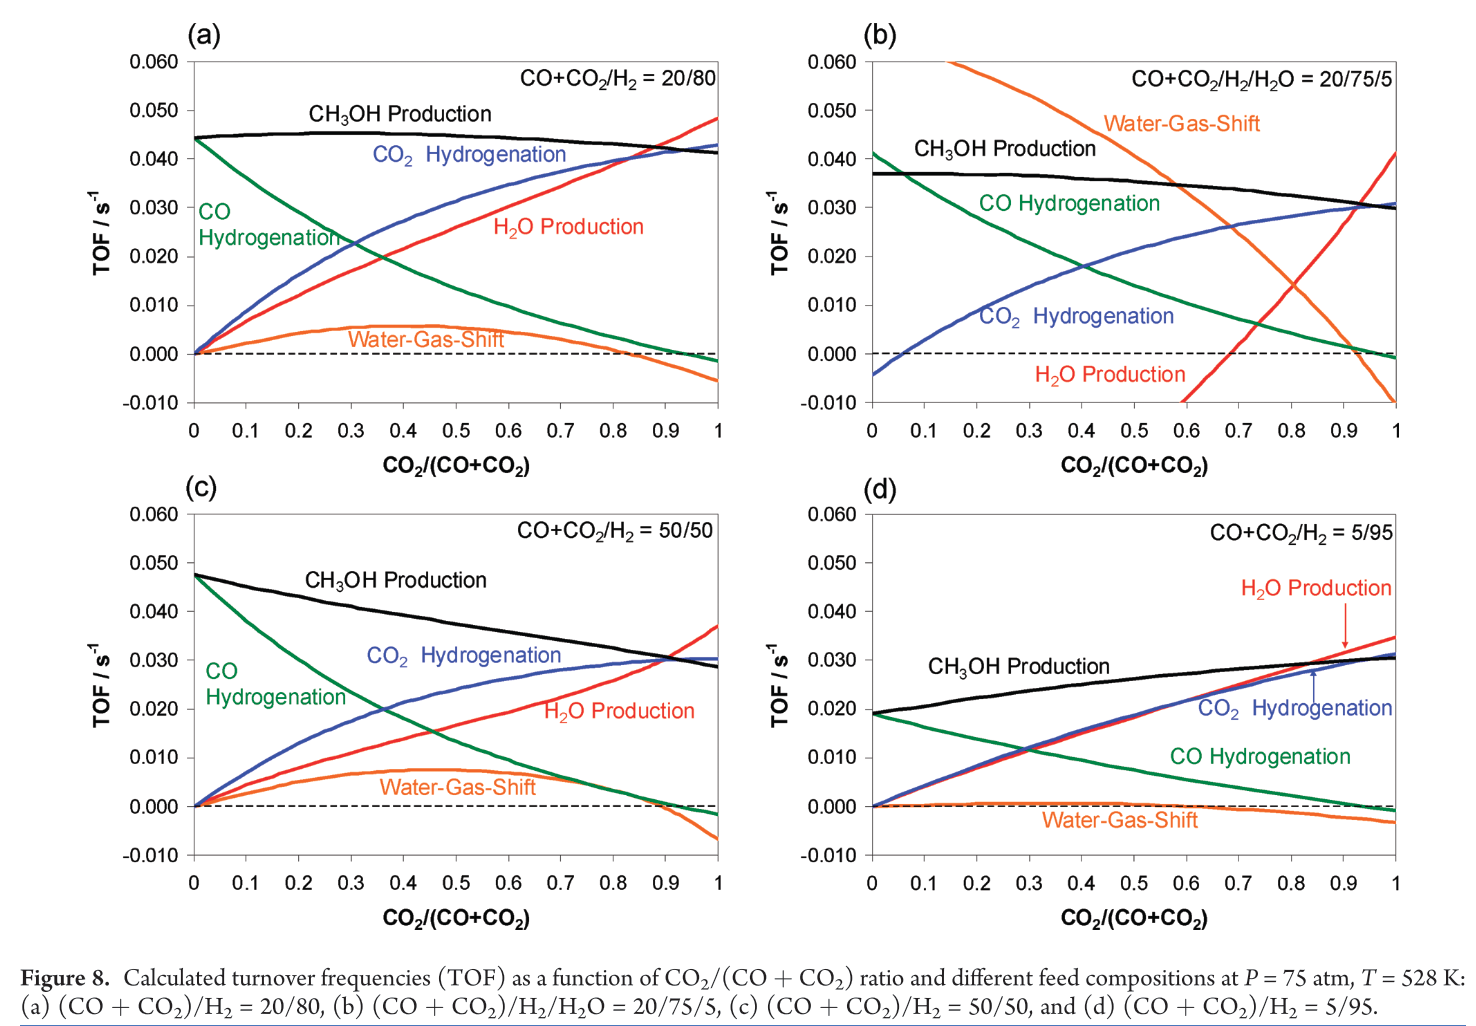

In [8]:
Image('../images/Grabow_plots/Grabow_TOF.png',width = 700, height = 300)

{0.5, 0.75, 0.8, 0.95}


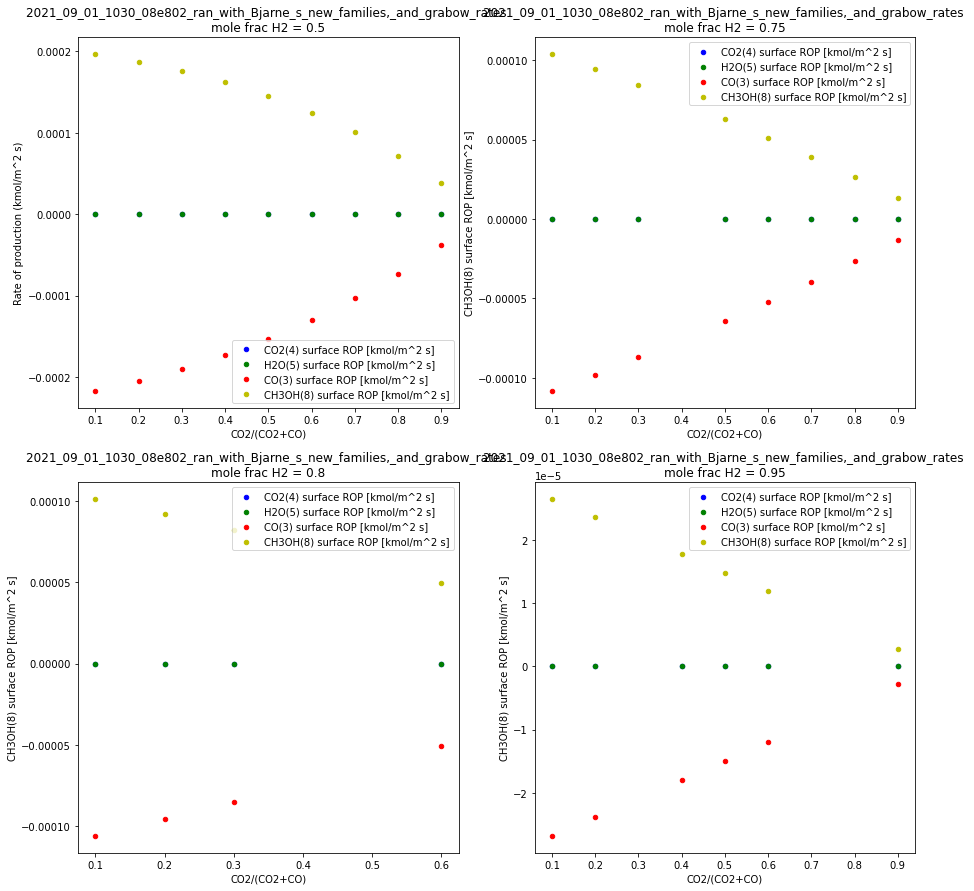

In [165]:
# compare the rate of production for CO2,  H2O, CO, and CH3OH
for commit in commit_list:
    
    #convert values to rounded values
#     data_dict[commit] = data_dict[commit].astype({'X_h2 initial':'float'})
#     data_dict[commit] = data_dict[commit].round({'X_h2 initial':2})
    
    if "0000_00_00_0000_000000_Grabow model" in commit:
        conditions = ['CO2 ROP [kmol/m^3 s]', 'H2O surface ROP [kmol/m^2 s]', \
                     'CO surface ROP [kmol/m^2 s]', 'CH3OH surface ROP [kmol/m^2 s]']
    else:
        conditions = ['CO2(4) surface ROP [kmol/m^2 s]', 'H2O(5) surface ROP [kmol/m^2 s]', \
                     'CO(3) surface ROP [kmol/m^2 s]', 'CH3OH(8) surface ROP [kmol/m^2 s]']
    temp = 528

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    print(H2_ratio)

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].autoscale(enable=True, axis='y')
                ax[0,0].set_ylabel("Rate of production (kmol/m^2 s)")
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("Rate of production (kmol/m^2 s)")

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c])
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("Rate of production (kmol/m^2 s)")

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("Rate of production (kmol/m^2 s)")
            



In [10]:
# get the maximum values
max_dist = 2
imp_species = []

df_short = data_dict[commit_list[0]]

thresh = 1e-4

for c in commit_list:
    print(f'\n{c}\nSpecies Steady state concentrations that go above :{thresh}', '\n')
    df_short = data_dict[c]
    for i in range (15, len(df_short.columns)):

        column = df_short[df_short.columns[i]]
        max_value = column.max()
        max_index = column.idxmax()

        if max_value >= thresh and (("X" in df_short.columns[i]) or \
                                  ("Pt" in df_short.columns[i]) or \
                                  ("Pd" in df_short.columns[i]) or \
                                  ("*" in df_short.columns[i])) \
        and not "ROP" in df_short.columns[i] \
        and not "sensitivity" in df_short.columns[i]:

            imp_species.append(df_short.columns[i])
            print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))


2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates
Species Steady state concentrations that go above :0.0001 

X(1) Max = 0.1862447134
H*(10) Max = 0.0066606204
H2O*(13) Max = 0.0009972837
CO*(14) Max = 0.9745890267
HCO*(16) Max = 0.0055258423
CH2O*(20) Max = 0.0002522969
CH3OH*(23) Max = 0.0033764418
H2X(53) Max = 0.9065452851


In [11]:
imp_species

['X(1)',
 'H*(10)',
 'H2O*(13)',
 'CO*(14)',
 'HCO*(16)',
 'CH2O*(20)',
 'CH3OH*(23)',
 'H2X(53)']

### display species with highest concentrations

HCO*(16)  

<img src="2021_08_19_1424_e3a38d_added_gitignore/species_pictures/HCO*(16).png"  width="100">

SX(58)
<img src="2021_08_19_1424_e3a38d_added_gitignore/species_pictures/SX(58).png"  width="100">

SX(56)
<img src="2021_08_19_1424_e3a38d_added_gitignore/species_pictures/SX(56).png"  width="100">

['X(1)', 'H*(10)', 'H2O*(13)', 'CO*(14)', 'HCO*(16)', 'CH2O*(20)', 'CH3OH*(23)', 'H2X(53)']


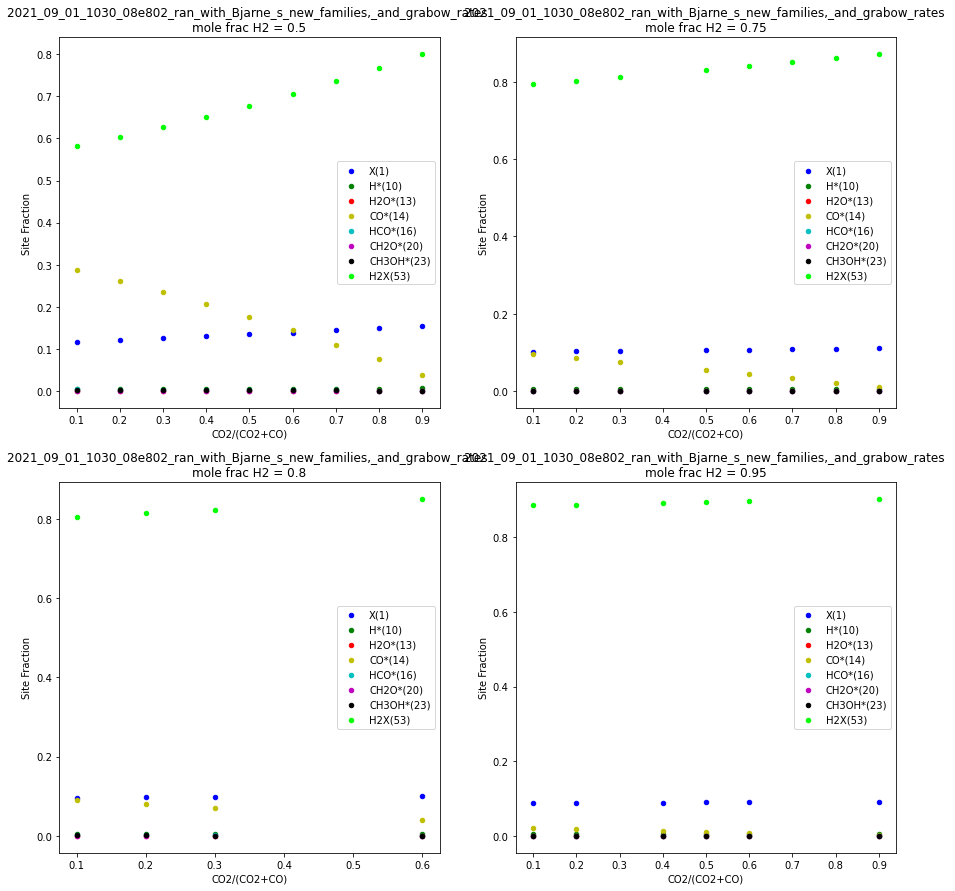

In [12]:
# compare the rate of production for CO2,  H2O, CO, and CH3OH
for commit in commit_list:
# commit = commit_list[0] 

    conditions = imp_species[:8]
    temp = 528

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    print(conditions)

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4:"c", 5:"m", 6: "k", 7: "lime" , 8:"brown"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("Site Fraction")
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,1].set_ylabel("Site Fraction")
        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],)
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,0].set_ylabel("Site Fraction")
        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,1].set_ylabel("Site Fraction")

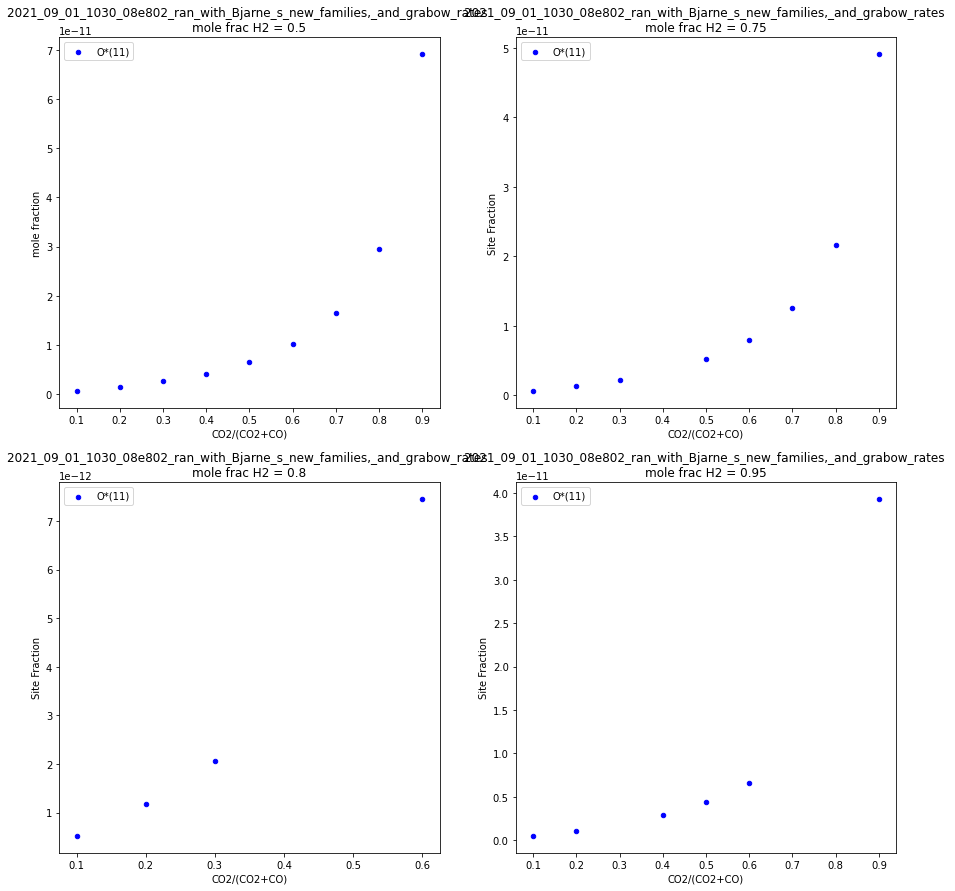

In [13]:
for commit in commit_list:
# commit = 'a95dd5_added_new_family_sur'  

    conditions = ["O*(11)"]
#     conditions = ["OX"]
    temp = 528

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    
    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4:"c", 5:"m"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("mole fraction")
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,1].set_ylabel("Site Fraction")
        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],)
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,0].set_ylabel("Site Fraction")
        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,1].set_ylabel("Site Fraction")

## Surface coverage comparison


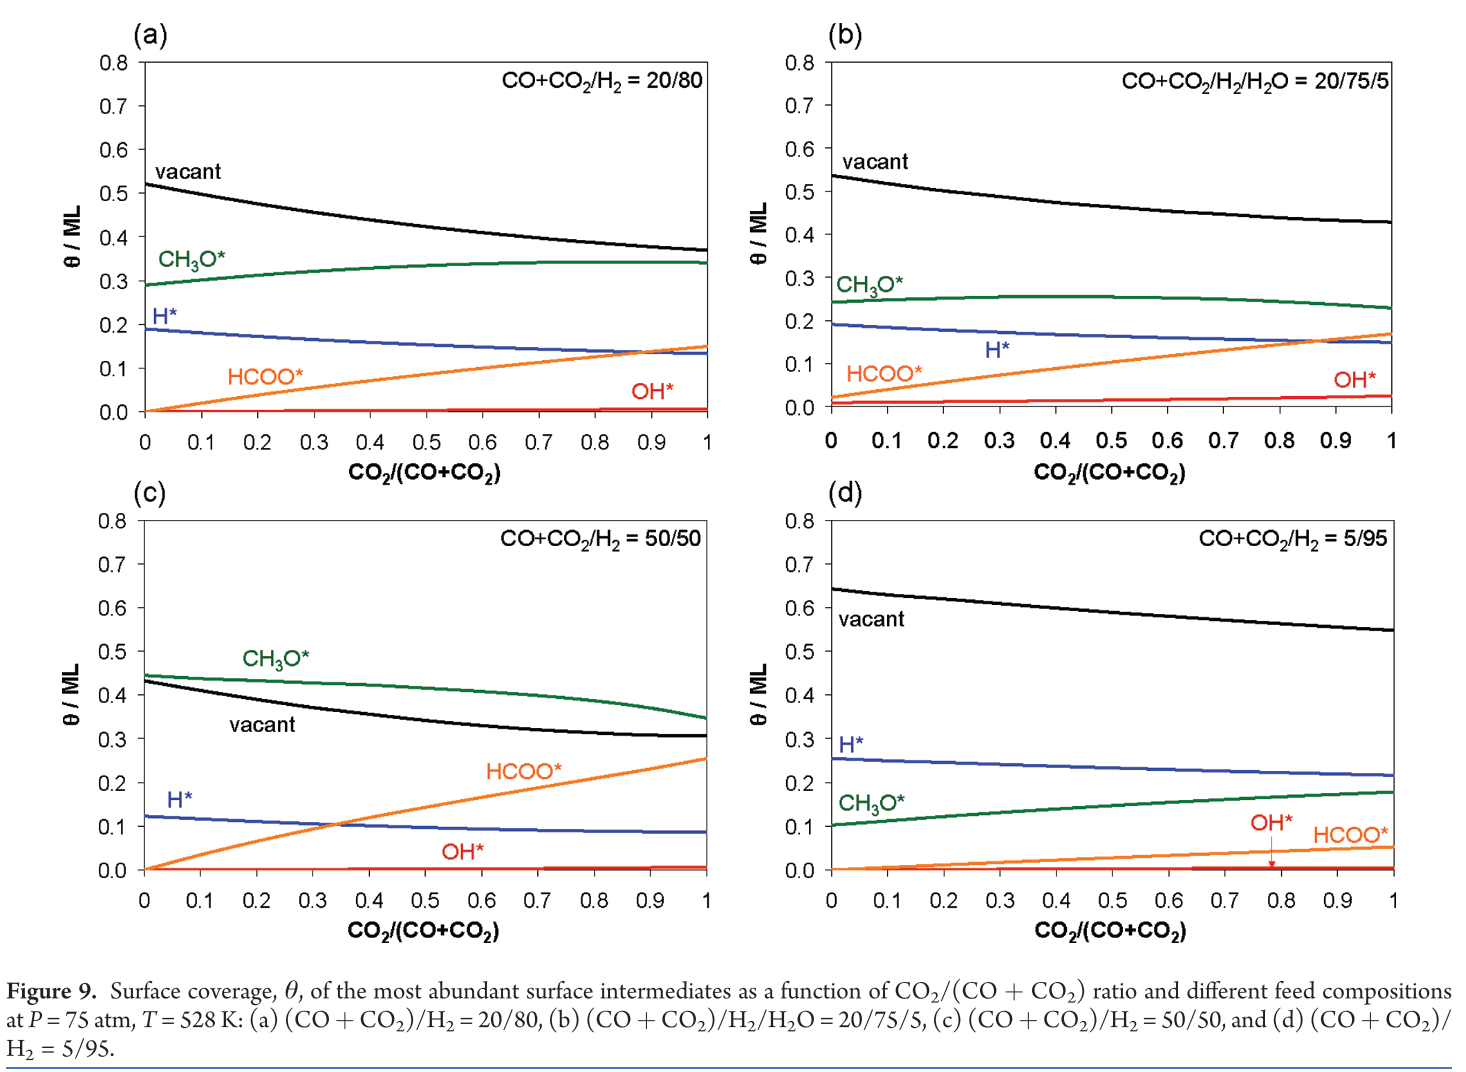

In [14]:
Image('../images/Grabow_plots/Grabow_coverage.png',width = 700, height = 300)

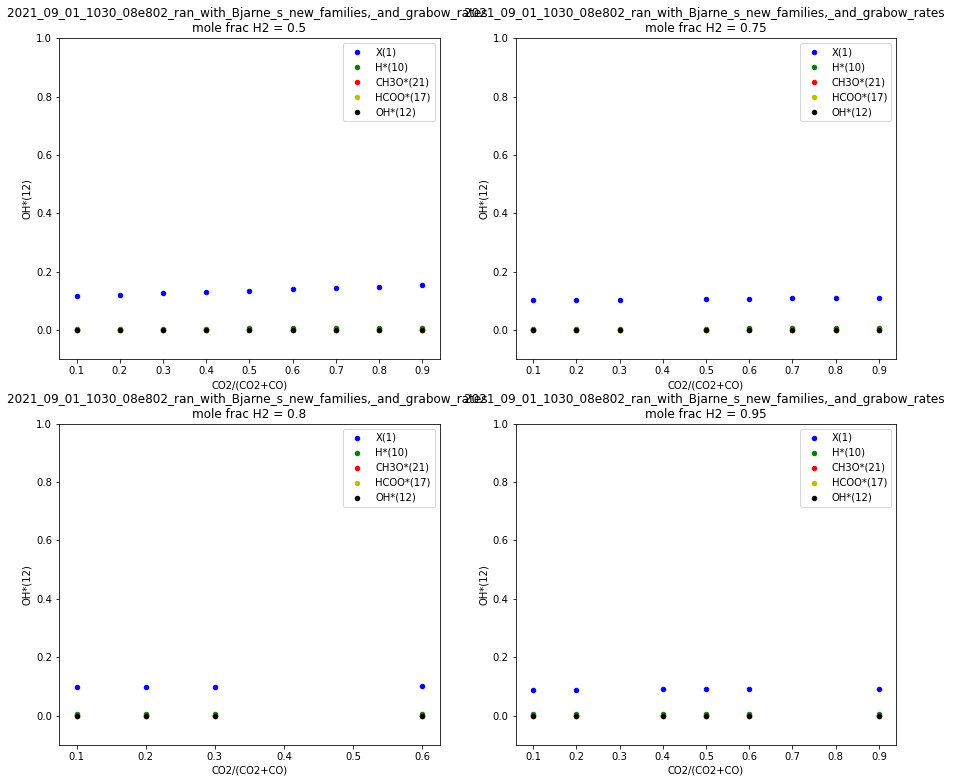

In [15]:
for commit in commit_list:  

    # removing HCOO because we ar using the wrong species
    conditions = ['X(1)', 'H*(10)', 'CH3O*(21)', 'HCOO*(17)', 'OH*(12)']
#     conditions = ['X(1)', 'H*(10)', 'HCOO*(17)', 'OH*(12)']
#     conditions = ['X', 'HX', 'HCOOX', 'OHX']   
    temp = 528

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    
    fig, ax = plt.subplots(2,2,figsize=(15,13))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4: "k"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],ylim=[-0.1,1.0])
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')

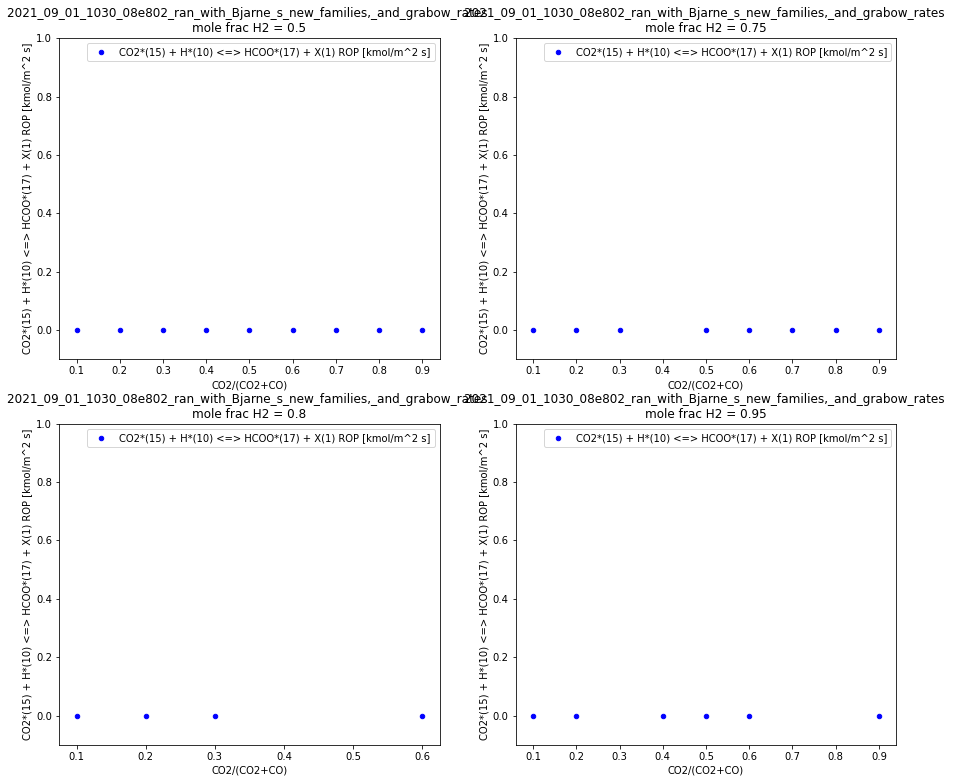

In [16]:
for commit in commit_list:  

    # removing HCOO because we ar using the wrong species
    conditions = ['CO2*(15) + H*(10) <=> HCOO*(17) + X(1) ROP [kmol/m^2 s]']
#     conditions = ['X(1)', 'H*(10)', 'HCOO*(17)', 'OH*(12)']
#     conditions = ['X', 'HX', 'HCOOX', 'OHX']   
    temp = 528

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    
    fig, ax = plt.subplots(2,2,figsize=(15,13))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4: "k"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],ylim=[-0.1,1.0])
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')

## flux diagrams

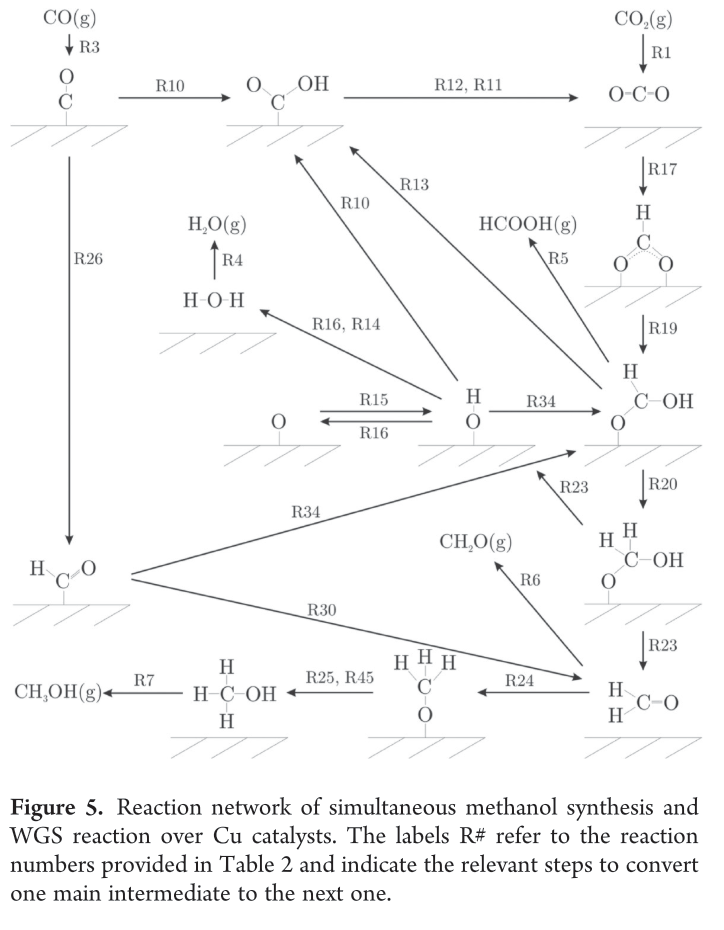

In [17]:
Image('../images/Grabow_plots/Grabow_rxn_path.png',width = 500, height = 300)

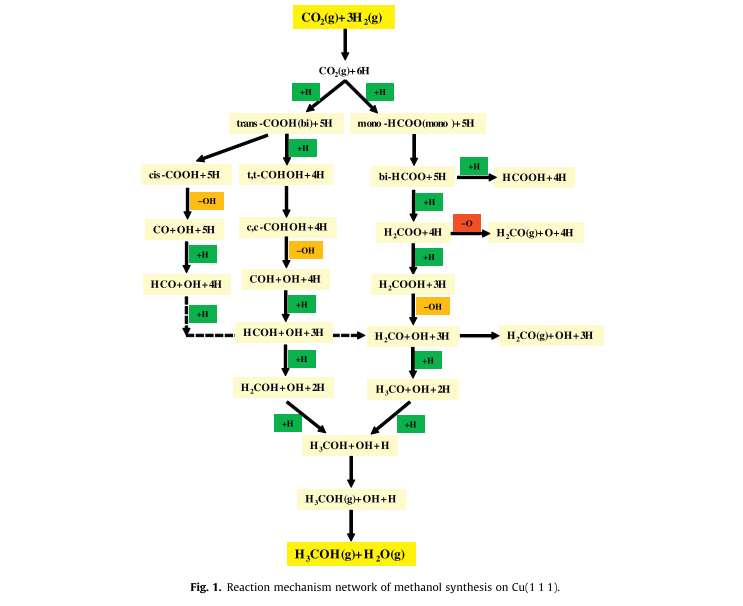

In [18]:
Image('../images/Reaction_mechanism_alternative.png',width = 700, height = 300)

description of commits: 


In [19]:
# commit_list[1] = '2021_7_12_1054_62027c_covdep_with_bjarne_s_data_and_modified_H2X_vdw_bin'
commit_list

['2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates']

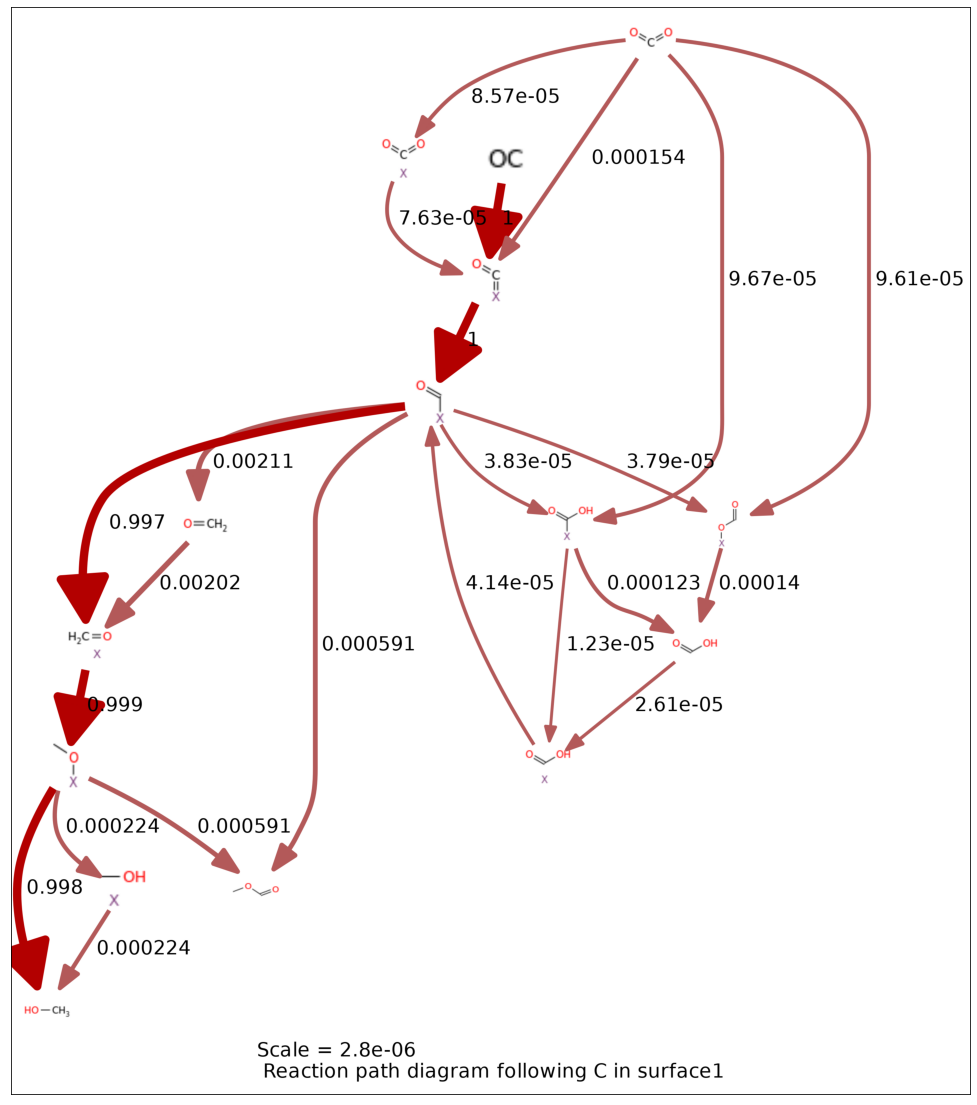

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import math

%matplotlib inline
img = []
flux_path = []

# determine # of rows and columns for displays
placeholder = [1,2,3,4,5]

one_commit = True


if not one_commit:
    rcParams['figure.figsize'] = 30 ,30
    if len(commit_list)%2 == 0:
        rows = int(len(commit_list)/2)
    else: 
        rows = int(math.ceil(len(commit_list)/2))

    fig, ax = plt.subplots(rows,2)
    for i,commit in enumerate(commit_list):
        temp = 528
        H2_frac = "0_7"
        CO_CO2 = "0_9"
        element = "O"
        phase = "surface1" # "surface1" "gas"
        time = "end" # "end" "beginning"
        prefix = '../RMG_model_analysis/'
        flux_path.append(f'/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/{temp}/flux_diagrams/{H2_frac}/{CO_CO2}/reaction_path_{element}_{phase}_{time}-pretty.png')

        print(commit)
        img.append(mpimg.imread(f'{prefix}{commit}{flux_path[i]}'))

        #determine placement of picture
        if i%2 == 0:
            row = int(i/2)-1
            col = 0
        else:
            row = int(math.ceil(i/2)) - 1
            col = 1

        ax[row,col].imshow(img[i])
        ax[row,col].get_xaxis().set_visible(False) 
        ax[row,col].get_yaxis().set_visible(False) 
        ax[row,col].set_title(f'{commit}', fontsize = 30)
        
else:
    rcParams['figure.figsize'] = 20 ,20
    fig, ax = plt.subplots(1,1)
    for i,commit in enumerate(commit_list):
        temp = 528 
        H2_frac = "0_9"
        CO_CO2 = "0_1"
        element = "C"
        phase = "surface1" # "surface1" "gas"
        time = "end" # "end" "beginning"
        prefix = '../RMG_model_analysis/'
        flux_path.append(f'/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/{temp}/flux_diagrams/{H2_frac}/{CO_CO2}/reaction_path_{element}_{phase}_{time}-pretty.png')


        img.append(mpimg.imread(f'{prefix}{commit}{flux_path[i]}'))

        ax.imshow(img[i])
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
#         ax.set_title(f'{commit}', fontsize = 30)

In [21]:
one_commit

True

### pathway analysis

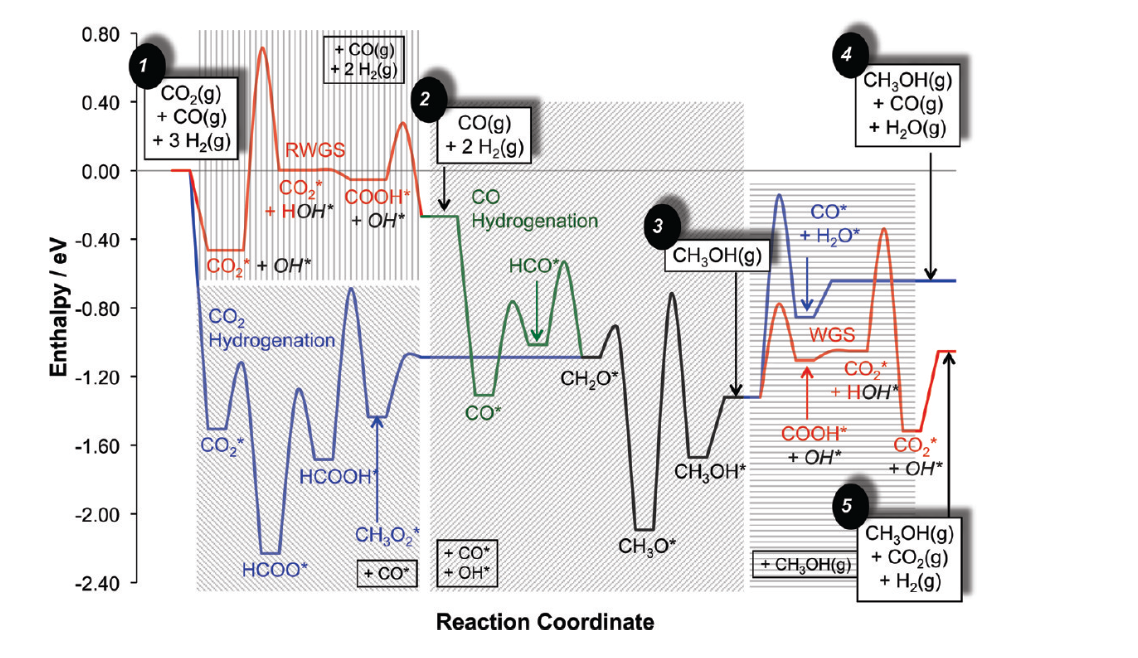

In [22]:
Image('../images/Grabow_plots/Grabow_PES.png',width = 1000, height = 300)

# Sensitivity

In [23]:
# load data into big data dictionary
sens_data_dict = {}
temps = [] 
X_h2s = []
X_coco2s = []

# excluded directories
exclude = ["/csp/", "/transient/", "sensitivity_off","thermo_sensitivity"]

for path in Path(commit).rglob('*.csv'):
    path_str = str(path)
    if os.stat(path_str).st_size != 0 and all(f not in path_str for f in exclude):
        data = pd.read_csv(path_str)
        print(len(data['T (K)']))
        #if we have more than 1 line of data, pull sensitivity
        if len(data['T (K)']) > 0: 
            temp = round(float(data['T (K)'][0]))
            X_h2 = round(float(data['X_h2 initial'][0]),2)
            print(X_h2)
            X_coco2 = round(float(data['CO2/(CO2+CO)'][0]),2)

            if temp not in temps: temps.append(temp)
            if X_h2 not in X_h2s: X_h2s.append(X_h2) 
            if X_coco2 not in X_coco2s: X_coco2s.append(X_coco2)

            sens_data_dict.update({(temp,X_h2,X_coco2) : data})
            print("sim_passed", path_str)
        else:
            print(path_str)
            print("empty data, sim crashed")

1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/400/results/Spinning_basket_area_0.0231_energy_off_temp_400_h2_0_5_COCO2_0_1.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/400/results/Spinning_basket_area_0.0231_energy_off_temp_400_h2_0_5_COCO2_0_2.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/400/results/Spinning_basket_area_0.0231_energy_off_temp_400_h2_0_5_COCO2_0_3.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/400/results/Spinning_basket_area_0.0231_energy_off_temp_400_h2_0_5_COCO2_0_4.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_

1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/500/results/Spinning_basket_area_0.0231_energy_off_temp_500_h2_0_5_COCO2_0_5.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/500/results/Spinning_basket_area_0.0231_energy_off_temp_500_h2_0_5_COCO2_0_6.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/500/results/Spinning_basket_area_0.0231_energy_off_temp_500_h2_0_5_COCO2_0_7.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/500/results/Spinning_basket_area_0.0231_energy_off_temp_500_h2_0_5_COCO2_0_8.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_

1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_6.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_7.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_8.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_9.csv
1
0.75
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and

1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/600/results/Spinning_basket_area_0.0231_energy_off_temp_600_h2_0_5_COCO2_0_8.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/600/results/Spinning_basket_area_0.0231_energy_off_temp_600_h2_0_5_COCO2_0_9.csv
1
0.75
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/600/results/Spinning_basket_area_0.0231_energy_off_temp_600_h2_0_7_COCO2_0_1.csv
1
0.75
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/kinetics_sensitivity/600/results/Spinning_basket_area_0.0231_energy_off_temp_600_h2_0_7_COCO2_0_2.csv
1
0.75
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_a

In [24]:
sens_data_dict[528, 0.5, 0.9]

time (s)  T (K)     P (Pa)  V (M^3/s)  X_co initial  X_co2initial  \
0  67.179936    528  7599375.0    0.00424          0.05          0.45   

   X_h2 initial  X_h2o initial  CO2/(CO2+CO)  (CO+CO2/H2)  ...  \
0           0.5            0.0           0.9          1.0  ...   

   CH3OH(8) sensitivity to H2X(53) + OH*(12) <=> H*(10) + H2O*(13)  \
0                                       1.637860e-07                 

   CH3OH(8) sensitivity to CO*(14) + H2X(53) <=> H*(10) + HCO*(16)  \
0                                      -1.298434e-07                 

   CH3OH(8) sensitivity to CO2*(15) + H2X(53) <=> H*(10) + HCOO*(17)  \
0                                       2.445517e-07                   

  CH3OH(8) sensitivity to CO2*(15) + H2X(53) <=> COOH*(18) + H*(10)  \
0                                      -9.790650e-08                  

  CH3OH(8) sensitivity to H2X(53) + HCOO*(17) <=> H*(10) + HCOOH*(19)  \
0                                       9.309628e-08                    

   CH3OH(8) sensitivity to COOH*(18) + H2X(53) <=> H*(10) + HCOOH*(19)  \
0                                      -6.262718e-07                     

   CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> H2X(53) + HCO*(16)  \
0                                            0.41191                   

   CH3OH(8) sensitivity to CH2O*(20) + H2X(53) <=> CH3O*(21) + H*(10)  \
0                                      -8.340518e-08                    

   CH3OH(8) sensitivity to H2X(53) + HCOOH*(19) <=> CH3O2*(22) + H*(10)  \
0                                       1.033813e-07                      

   CH3OH(8) sensitivity to CH3O*(21) + H2X(53) <=> CH3OH*(23) + H*(10)  
0                                           0.000002                    

[1 rows x 336 columns]

In [26]:
def max_sensitivities(df, number=0):
    # make a dictionary of highest sensitivity (tuple?)
    columns = {}
    for key, value in df.iteritems():
        if "sensitivity" in key and "thermo" not in key:
            max_sens = value.max()
            min_sens = value.min()
            
            if abs(max_sens) >= abs(min_sens):
                extreme_sens = max_sens
            elif abs(max_sens) < abs(min_sens):
                extreme_sens = min_sens
                
                
            columns.update({key:extreme_sens})

    if number !=0:
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True)[:number])
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False)[:number])
    else: 
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True))
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False))
    return columns, columns_rev


columns, columns_rev = max_sensitivities(sens_data_dict[528, 0.5, 0.9],5)
columns

{'CH3OH(8) sensitivity to CO(3) + X(1) <=> CO*(14)': 0.5460309779218373,
 'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> H2X(53) + HCO*(16)': 0.4119103157300906,
 'CH3OH(8) sensitivity to H*(10) + HCO*(16) <=> CH2O*(20) + X(1)': 0.3557438756619959,
 'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> CH3O*(21) + X(1)': 0.13246730483606553,
 'CH3OH(8) sensitivity to H2(2) + X(1) <=> H2X(53)': 0.061659715646261014}

In [27]:
def max_thermo_sensitivities(df, number=0):
    # make a dictionary of highest sensitivity (tuple?)
    columns = {}
    for key, value in df.iteritems():
        if "sensitivity" in key and "thermo" in key:
            max_sens = value.max()
            min_sens = value.min()
            
            if abs(max_sens) >= abs(min_sens):
                extreme_sens = max_sens
            elif abs(max_sens) < abs(min_sens):
                extreme_sens = min_sens
                
                
            columns.update({key:extreme_sens})

    if number !=0:
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True)[:number])
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False)[:number])
    else: 
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True))
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False))
    return columns, columns_rev


columns, columns_rev = max_thermo_sensitivities(sens_data_dict[528, 0.5, 0.7],5)
columns_rev

{}

In [28]:
columns

{}

In [148]:
from matplotlib.pyplot import figure
%matplotlib inline

figure(figsize=(8, 20), dpi=80)

# plot the top sensitivities for a dataframe
def plot_sensitivities(df, num = 5, align="center", height=0.2, label = ""):
    
    imp_reactions_pos, imp_reactions_neg = max_sensitivities(df,num)
    imp_reactions = {**imp_reactions_pos, **imp_reactions_neg}
    
    fig, ax = plt.subplots()
    
    ax.barh(*zip(*imp_reactions.items()),height=height, log=True, align=align,alpha=0.8, label=label)
    ax.set_xlabel("Sensitivity Coefficient")


def plot_thermo_sensitivities(df, num = 5, align="center", height=0.2, label = ""):
    
    imp_reactions_pos, imp_reactions_neg = max_thermo_sensitivities(df,num)
    imp_reactions = {**imp_reactions_pos, **imp_reactions_neg}
    
    fig, ax = plt.subplots()

    ax.barh(*zip(*imp_reactions.items()),height=height, log=True, align=align,alpha=0.8, label=label)
    ax.set_xlabel("Sensitivity Coefficient")

    
def plot_multi_sensitivities(df_1, df_2, df_3, num = 5, align="center", height=0.2, label = ""):
    
    imp_reactions_pos_1, imp_reactions_neg_1 = max_sensitivities(df_1,num)
    imp_reactions_pos_2, imp_reactions_neg_2 = max_sensitivities(df_2,num)
    imp_reactions_pos_3, imp_reactions_neg_3 = max_sensitivities(df_3,num)
    
    imp_reactions_1 = pd.DataFrame.from_dict({**imp_reactions_pos_1, **imp_reactions_neg_1}, orient='index')
    imp_reactions_1.columns = [str(df_1['T (K)'][0]) + " K"]
    imp_reactions_2 = pd.DataFrame.from_dict({**imp_reactions_pos_2, **imp_reactions_neg_2}, orient='index')
    imp_reactions_2.columns = [str(df_2['T (K)'][0]) + " K"]
    imp_reactions_3 = pd.DataFrame.from_dict({**imp_reactions_pos_3, **imp_reactions_neg_3}, orient='index')
    imp_reactions_3.columns = [str(df_3['T (K)'][0]) + " K"]
    
    # merge 
    merged = pd.concat([imp_reactions_1, imp_reactions_2, imp_reactions_3], axis=1)
    merged.plot.barh()

#     ax.barh(*zip(*imp_reactions_1.items()),height=height, log=True, align="center",alpha=0.8, label=label)
#     ax.barh(*zip(*imp_reactions_2.items()),height=height, log=True, align="edge",alpha=0.8, label=label)
#     ax.barh(*zip(*imp_reactions_3.items()),height=height, log=True, align="edge",alpha=0.8, label=label)
#     ax.set_xlabel("Sensitivity Coefficient")


<Figure size 640x1600 with 0 Axes>

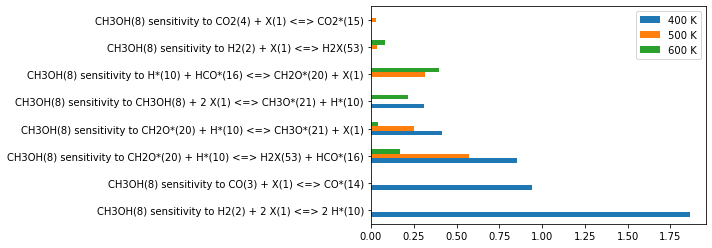

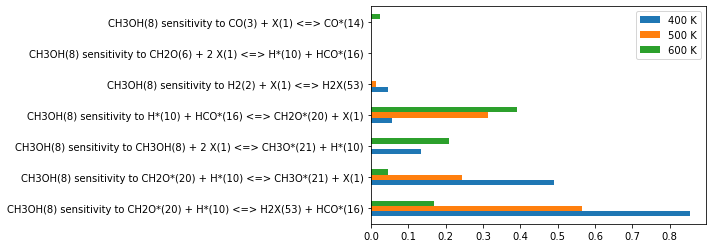

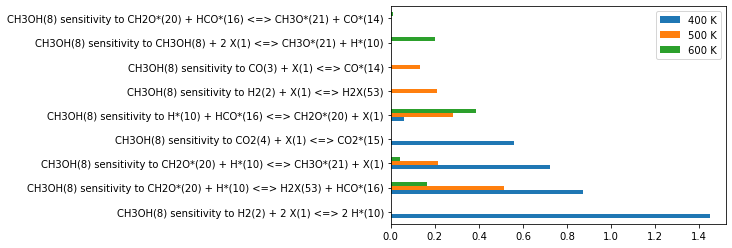

In [149]:
# kinetic sensitivities
plot_multi_sensitivities(
    sens_data_dict[400, 0.5, 0.1],
    sens_data_dict[500, 0.5, 0.1],
    sens_data_dict[600, 0.5, 0.1],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.5, 0.5],
    sens_data_dict[500, 0.5, 0.5],
    sens_data_dict[600, 0.5, 0.5],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.5, 0.9],
    sens_data_dict[500, 0.5, 0.9],
    sens_data_dict[600, 0.5, 0.9],
    5, 
    "center"
)

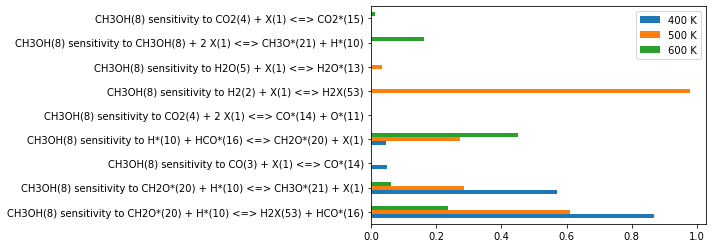

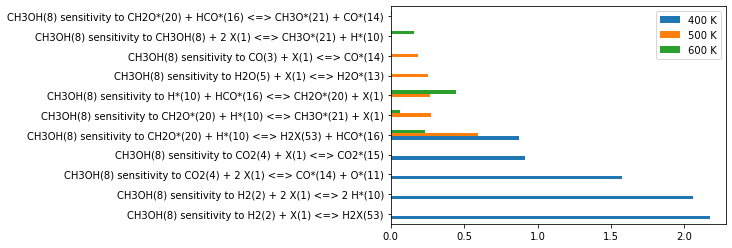

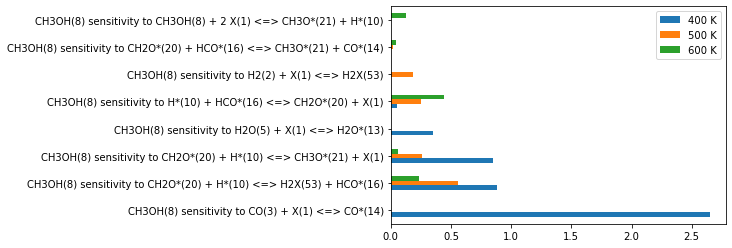

In [152]:
# kinetic sensitivities
plot_multi_sensitivities(
    sens_data_dict[400, 0.75, 0.1],
    sens_data_dict[500, 0.75, 0.1],
    sens_data_dict[600, 0.75, 0.1],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.75, 0.5],
    sens_data_dict[500, 0.75, 0.5],
    sens_data_dict[600, 0.75, 0.5],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.75, 0.9],
    sens_data_dict[500, 0.75, 0.9],
    sens_data_dict[600, 0.75, 0.9],
    5, 
    "center"
)

In [154]:
sens_data_dict.keys()

dict_keys([(400, 0.5, 0.9), (400, 0.5, 0.8), (400, 0.5, 0.7), (400, 0.5, 0.6), (400, 0.5, 0.5), (400, 0.5, 0.4), (400, 0.5, 0.3), (400, 0.5, 0.2), (400, 0.5, 0.1), (400, 0.75, 0.9), (400, 0.75, 0.8), (400, 0.75, 0.7), (400, 0.75, 0.6), (400, 0.75, 0.5), (400, 0.75, 0.4), (400, 0.75, 0.3), (400, 0.75, 0.2), (400, 0.75, 0.1), (400, 0.8, 0.8), (400, 0.8, 0.7), (400, 0.8, 0.6), (400, 0.8, 0.5), (400, 0.8, 0.4), (400, 0.8, 0.3), (400, 0.8, 0.2), (400, 0.8, 0.1), (400, 0.95, 0.9), (400, 0.95, 0.6), (400, 0.95, 0.5), (400, 0.95, 0.3), (400, 0.95, 0.2), (400, 0.95, 0.1), (500, 0.5, 0.9), (500, 0.5, 0.8), (500, 0.5, 0.7), (500, 0.5, 0.6), (500, 0.5, 0.5), (500, 0.5, 0.4), (500, 0.5, 0.3), (500, 0.5, 0.2), (500, 0.5, 0.1), (500, 0.75, 0.9), (500, 0.75, 0.8), (500, 0.75, 0.7), (500, 0.75, 0.6), (500, 0.75, 0.5), (500, 0.75, 0.4), (500, 0.75, 0.3), (500, 0.75, 0.2), (500, 0.75, 0.1), (500, 0.8, 0.9), (500, 0.8, 0.8), (500, 0.8, 0.7), (500, 0.8, 0.6), (500, 0.8, 0.5), (500, 0.8, 0.4), (500, 0.8, 0.

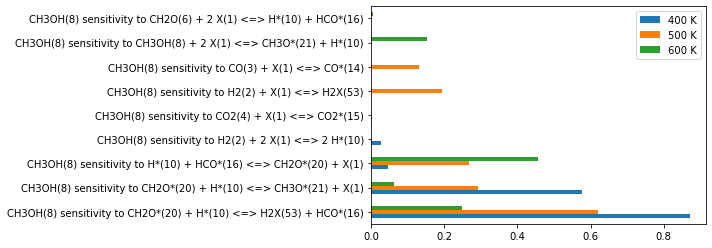

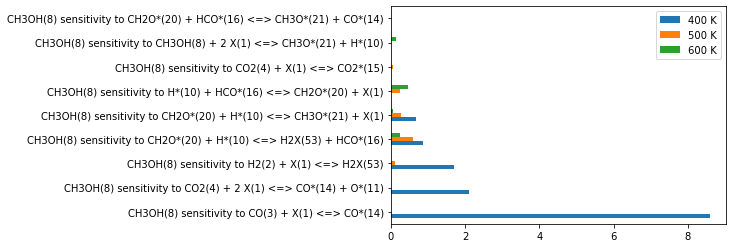

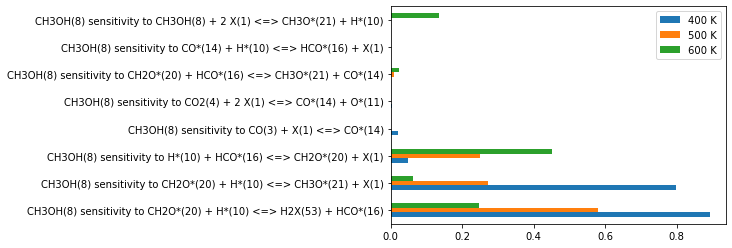

In [156]:
# kinetic sensitivities
plot_multi_sensitivities(
    sens_data_dict[400, 0.8, 0.1],
    sens_data_dict[500, 0.8, 0.1],
    sens_data_dict[600, 0.8, 0.1],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.8, 0.5],
    sens_data_dict[500, 0.8, 0.5],
    sens_data_dict[600, 0.8, 0.5],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.8, 0.8],
    sens_data_dict[500, 0.8, 0.8],
    sens_data_dict[600, 0.8, 0.8],
    5, 
    "center"
)

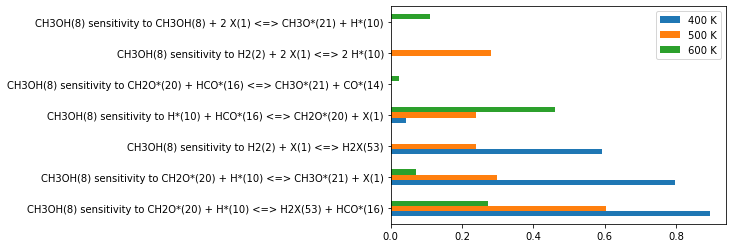

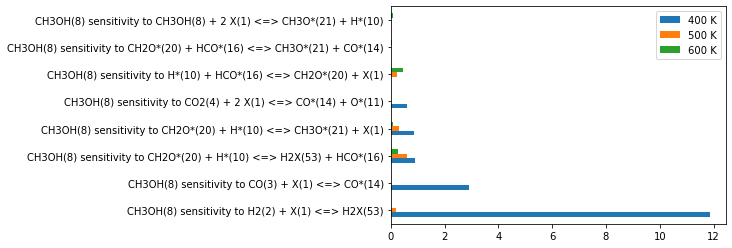

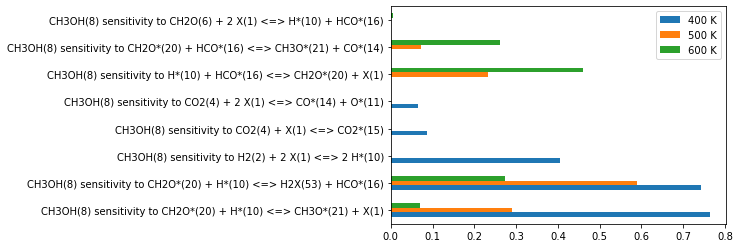

In [150]:
# kinetic sensitivities
plot_multi_sensitivities(
    sens_data_dict[400, 0.95, 0.1],
    sens_data_dict[500, 0.95, 0.1],
    sens_data_dict[600, 0.95, 0.1],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.95, 0.5],
    sens_data_dict[500, 0.95, 0.5],
    sens_data_dict[600, 0.95, 0.5],
    5, 
    "center"
)
plot_multi_sensitivities(
    sens_data_dict[400, 0.95, 0.9],
    sens_data_dict[500, 0.95, 0.9],
    sens_data_dict[600, 0.95, 0.9],
    5, 
    "center"
)

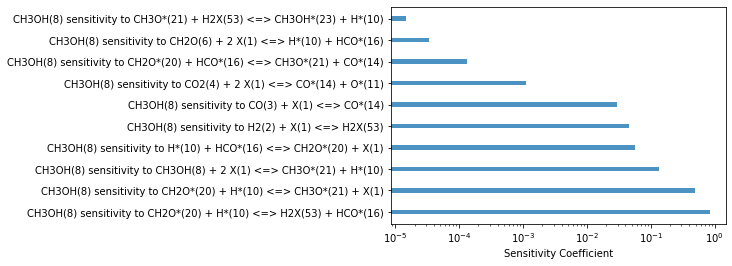

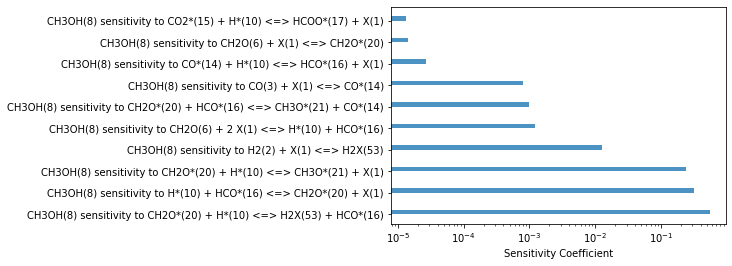

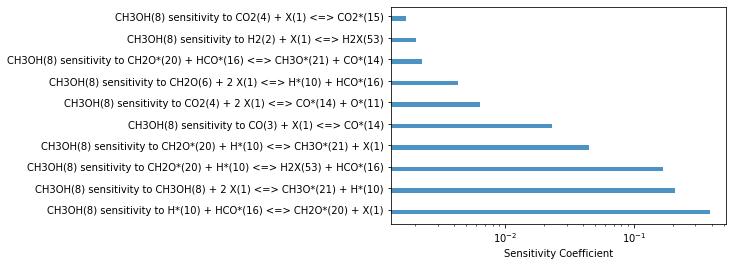

In [44]:
# kinetic sensitivities
plot_sensitivities(sens_data_dict[400, 0.5, 0.5],10, "center")
plot_sensitivities(sens_data_dict[500, 0.5, 0.5],10, "edge")
plot_sensitivities(sens_data_dict[600, 0.5, 0.5],10, "edge", height=-0.2)

### thermo sensitivities

In [57]:
# load data into big data dictionary
sens_data_dict = {}
temps = [] 
X_h2s = []
X_coco2s = []

# excluded directories
exclude = ["/csp/", "/transient/", "sensitivity_off"]
include = "thermo_sensitivity"

for path in Path(commit).rglob('*.csv'):
    path_str = str(path)
    if os.stat(path_str).st_size != 0 and all(f not in path_str for f in exclude) and include in path_str:
        data = pd.read_csv(path_str)
        print(len(data['T (K)']))
        #if we have more than 1 line of data, pull sensitivity
        if len(data['T (K)']) > 0: 
            temp = round(float(data['T (K)'][0]))
            X_h2 = round(float(data['X_h2 initial'][0]),2)
            print(X_h2)
            X_coco2 = round(float(data['CO2/(CO2+CO)'][0]),2)

            if temp not in temps: temps.append(temp)
            if X_h2 not in X_h2s: X_h2s.append(X_h2) 
            if X_coco2 not in X_coco2s: X_coco2s.append(X_coco2)

            sens_data_dict.update({(temp,X_h2,X_coco2) : data})
            print("sim_passed", path_str)
        else:
            print(path_str)
            print("empty data, sim crashed")

1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/thermo_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_1.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/thermo_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_2.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/thermo_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_3.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates/steady_state/IdealGasReactor/energy_off/thermo_sensitivity/528/results/Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_4.csv
1
0.5
sim_passed 2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_r

In [58]:
sens_data_dict.keys()

dict_keys([(528, 0.5, 0.9), (528, 0.5, 0.8), (528, 0.5, 0.7), (528, 0.5, 0.6), (528, 0.5, 0.5), (528, 0.5, 0.4), (528, 0.5, 0.3), (528, 0.5, 0.2), (528, 0.5, 0.1), (528, 0.75, 0.8), (528, 0.75, 0.6), (528, 0.75, 0.5), (528, 0.75, 0.4), (528, 0.75, 0.3), (528, 0.75, 0.2), (528, 0.75, 0.1), (528, 0.8, 0.8), (528, 0.8, 0.7), (528, 0.8, 0.6), (528, 0.8, 0.5), (528, 0.8, 0.4), (528, 0.8, 0.3), (528, 0.8, 0.2), (528, 0.8, 0.1), (528, 0.95, 0.9), (528, 0.95, 0.8), (528, 0.95, 0.6)])

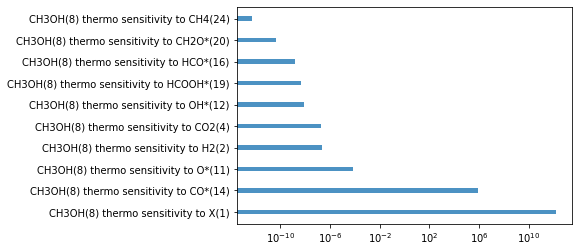

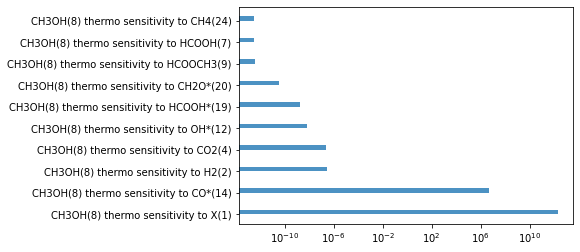

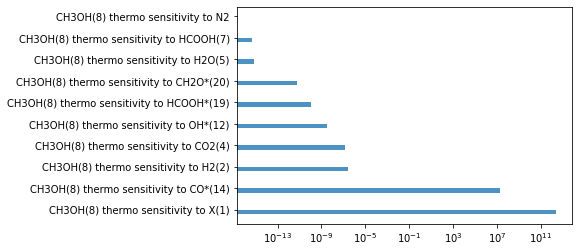

In [60]:
# figure(figsize=(8, 20), dpi=80)

plot_thermo_sensitivities(sens_data_dict[528, 0.5, 0.9],10, "center", label="0.9")
plot_thermo_sensitivities(sens_data_dict[528, 0.5, 0.5],10, "edge",label="0.")
plot_thermo_sensitivities(sens_data_dict[528, 0.5, 0.1],10, "edge", height=-0.2, label="0.6")

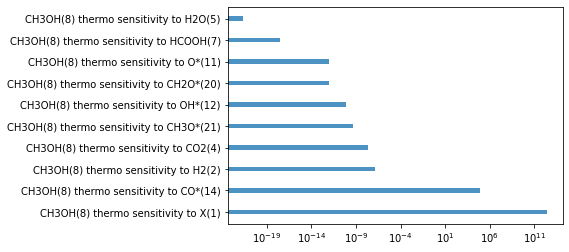

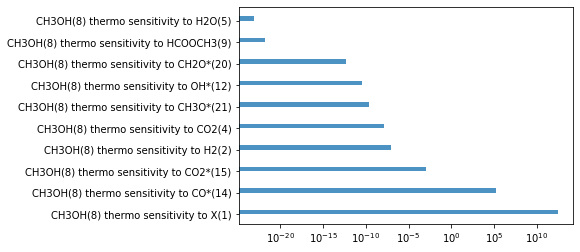

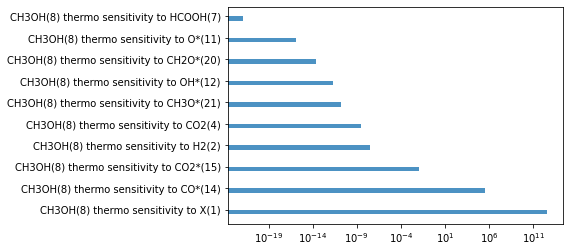

In [63]:
# figure(figsize=(8, 20), dpi=80)

plot_thermo_sensitivities(sens_data_dict[528, 0.95, 0.9],10, "center", label="0.9")
plot_thermo_sensitivities(sens_data_dict[528, 0.95, 0.8],10, "edge",label="0.")
plot_thermo_sensitivities(sens_data_dict[528, 0.95, 0.6],10, "edge", height=-0.2, label="0.6")

## Get common sensitivities

get common sensitive reactions (with an average sensitivity) 

In [135]:
sensitivities = {}
# i = key, j = dict
for i,j in sens_data_dict.items():
    columns, columns_rev = max_sensitivities(sens_data_dict[i],10)
    sensitivities[i] = columns


common_sensitivities = {}
# compare all of the reaction strings, and see if we have common sensitivities 
for i,j in sensitivities.items():
    for k,l in j.items():
        if k in common_sensitivities.keys():
            common_sensitivities[k] = common_sensitivities[k] + [l]
        else: 
            common_sensitivities[k] = [float(l)]
            

for i,j in common_sensitivities.items():
    common_sensitivities[i] = [sum(j) / len(j)]
    
df_sens_avg = pd.DataFrame.from_dict(common_sensitivities, orient='index', columns=["avg sensitivity"])

add reaction metadata to dataframe 

In [136]:
reactions = list(common_sensitivities.keys())
reac_species = {}
for i,j in enumerate(reactions):
    string = j[24:].replace("+"," ").replace("<=>", "").replace("2 ", "")
    string = string.split()
    
    reac_species[j] = string

In [137]:
# list of lists containing species in each reaction (makes search in cti file easier)
reac_inline = 0
comment_lines = []
reac_flag = False

with open("/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti") as f:
    for linenum,line in enumerate(f):
        if reac_flag == False:
            comment_lines = []
            # loop through dictionary n = sensitivity string and r = list of reactants
            for n,r in reac_species.items(): 
                reac_inline = 0
                if all(item in line for item in r) and not line.startswith("#"):
                    print(linenum, line)
                    reac_flag = True
                    rxn = n
                    continue
                        
                
                  
        if reac_flag == True:
            if line.startswith("#"):
                comment_lines.append(line)
            elif len(comment_lines) > 0:
                
                common_sensitivities[rxn].append(comment_lines)
                rxn = ""
                reac_flag = False

15                           HCOO*(17)   COOH*(18)   HCOOH*(19)  CH2O*(20)

497 reaction('H2(2) + CO(3) <=> CH2O(6)', [2.890000e+09, 1.16, 82.1],

518 reaction('H2(2) + CO2(4) <=> HCOOH(7)', [1.510000e+09, 1.23, 73.9],

529 reaction('CO(3) + CH3OH(8) <=> HCOOCH3(9)', [1.270000e-01, 3.7, 53.36],

550 reaction('H2(2) + CO2(4) <=> HCOOH(7)', [1.510000e+09, 1.23, 73.9],

561 reaction('H2(2) + CO2(4) <=> HCOOH(7)', [1.510000e+09, 1.23, 73.9],

734 surface_reaction('X(1) + CH3OH(8) <=> CH3OH*(23)', stick(1.000000e-01, 0.0, 0.0),

745 surface_reaction('X(1) + X(1) + CO2(4) <=> O*(11) + CO*(14)', stick(2.000000e-02, 0.0, 10.0),

757 surface_reaction('X(1) + X(1) + H2O(5) <=> H*(10) + OH*(12)', stick(3.000000e-02, 0.0, 14.25),

778 surface_reaction('X(1) + X(1) + HCOOH(7) <=> OH*(12) + HCO*(16)', stick(1.500000e-02, 0.0, 6.912),

798 surface_reaction('X(1) + X(1) + HCOOH(7) <=> H*(10) + COOH*(18)', stick(1.500000e-02, 0.0, 1.195),

809 surface_reaction('X(1) + X(1) + CH3OH(8) <=> H*(10) + CH3O*

In [138]:
common_sensitivities

{'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> CH3O*(21) + X(1)': [37995.118913029175,
  ['#  Reaction index: Chemkin #38; RMG #136\n',
   '#  Template reaction: Surface_Addition_Single_vdW\n',
   '#  Flux pairs: CH2O*(20), CH3O2*(22); OH*(12), CH3O2*(22);\n',
   '#  Matched reaction 23 CH2O* + OH* <=> CH3O2* + X_5 in Surface_Addition_Single_vdW/training\n',
   '#  This reaction matched rate rule [O=C;HO*]\n',
   '#  family: Surface_Addition_Single_vdW\n',
   '#  metal: None\n']],
 'CH3OH(8) sensitivity to CH2O*(20) + HCO*(16) <=> CH3O*(21) + CO*(14)': [1.8791861901332656,
  ['#  Reaction index: Chemkin #78; RMG #492\n',
   '#  Template reaction: Surface_Adsorption_Abstraction_vdW\n',
   '#  Flux pairs: COOH*(18), CH3O2*(22); CH2O*(20), CO*(14);\n',
   '#  Estimated using an average for rate rule [O=C;*C-R]\n',
   '#  Euclidian distance = 0\n',
   '#  family: Surface_Adsorption_Abstraction_vdW\n']],
 'CH3OH(8) sensitivity to CH3O*(21) + H2X(53) <=> CH3OH*(23) + H*(10)': [1.0903820467

In [139]:
df_sens_avg = pd.DataFrame.from_dict(common_sensitivities, orient='index',)
df_sens_avg.to_csv("average_common_sensitivities.csv")

## get sensitive species from reactions

In [140]:
reactions = list(common_sensitivities.keys())
species = []
for i,j in enumerate(reactions):
    string = j[24:].replace("+"," ").replace("<=>", "").replace("2 ", "")
    string = string.split()
    
    for k in string:
        if k not in species:
            species.append(k)

In [141]:
len(species)

26

### get difference and see which species are less important

In [142]:
import cantera as ct
cti_file = "/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti"
gas = ct.Solution(cti_file)
surf = ct.Interface(cti_file, "surface1", [gas])

all_species = gas.species_names + surf.species_names

diff = [x for x in all_species if x not in species]
diff

['N2',
 'Ne',
 'CH4(24)',
 'CH3OX(49)',
 'CH2OX2(55)',
 'SX(56)',
 'COXX(63)',
 'CHOX2(64)',
 'CH4X(66)',
 'SX(277)',
 'SX(350)',
 'SX(386)']

In [143]:
species

['CH2O*(20)',
 'H*(10)',
 'CH3O*(21)',
 'X(1)',
 'HCO*(16)',
 'CO*(14)',
 'H2X(53)',
 'CH3OH*(23)',
 'HCOOH(7)',
 'COOH*(18)',
 'OH*(12)',
 'H2O*(13)',
 'CO2*(15)',
 'O*(11)',
 'CO2(4)',
 'H2(2)',
 'HCOOH(7).2',
 'HCOOH*(19)',
 'CH3O2*(22)',
 'CH3OH(8)',
 'HCOO*(17)',
 'CO(3)',
 'CH2O(6)',
 'HCOOH(7).1',
 'HCOOCH3(9)',
 'H2O(5)']